In [1]:
import sys
import os
sys.path.append('..')
from adjoint_esn.dynamical_systems import Lorenz63, Lorenz96, RoesslerLorenz
import adjoint_esn.solve_ode as solve_ode
import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.utils import preprocessing as pp

In [ ]:
# run lorenz63 system
my_lorenz63 = Lorenz63(beta=8/3, rho=28, sigma=10, t_lyap=0.906**(-1))

dt = 1e-2

t_transient_len = 200
t_washout_len = 2
t_train_len = 50*my_lorenz63.t_lyap
t_val_len = 15*my_lorenz63.t_lyap
t_sim_len = t_transient_len+2*t_washout_len+t_train_len+t_val_len

upsample = 2
t_sim = np.arange(0,t_sim_len,dt/upsample)
rnd = np.random.RandomState(seed = 10)
u0 = rnd.random((my_lorenz63.N_dim)) 
U_sim = solve_ode.integrate(my_lorenz63, u0, t_sim, integrator='forward_euler')

In [ ]:
# run lorenz96 system
my_lorenz96 = Lorenz96(p = 8.0, t_lyap = 1.2**(-1))

dt = 1e-2

t_transient_len = 200
t_washout_len = 2
t_train_len = 50*my_lorenz96.t_lyap
t_val_len = 15*my_lorenz96.t_lyap
t_sim_len = t_transient_len+2*t_washout_len+t_train_len+t_val_len

upsample = 2
t_sim = np.arange(0,t_sim_len,dt/upsample)
rnd = np.random.RandomState(seed = 10)
u0 = rnd.random((6)) 
U_sim = solve_ode.integrate(my_lorenz96, u0, t_sim, integrator='forward_euler')[:,2][:,None]

In [ ]:
# run coupled rössler lorenz
my_roesslor = RoesslerLorenz(a = 0.1, b = 0.1, c = 18, mu = 10, r = 28, d = 8/3, epsilon = 0.4)

dt = 1e-2

t_transient_len = 0
t_washout_len = 20
t_train_len = 2400
t_val_len = 120
t_sim_len = t_transient_len+2*t_washout_len+t_train_len+t_val_len

upsample = 1
t_sim = np.arange(0,t_sim_len,dt/upsample)
rnd = np.random.RandomState(seed = 10)
u0 = rnd.random((my_roesslor.N_dim)) 
U_sim = solve_ode.integrate(my_roesslor, u0, t_sim)

In [72]:
def load_data_roesslor(a, b, c, mu, r, d, epsilon):
   my_roesslor = RoesslerLorenz(a, b, c, mu, r, d, epsilon)

   dt = 1e-2

   t_transient_len = 0
   t_washout_len = 20
   t_train_len = 800
   t_val_len = 80
   t_sim_len = t_transient_len+2*t_washout_len+t_train_len+t_val_len

   upsample = 1
   t_sim = np.arange(0,t_sim_len,dt/upsample)
   rnd = np.random.RandomState(seed = 10)
   u0 = rnd.random((my_roesslor.N_dim)) 
   U_sim = solve_ode.integrate(my_roesslor, u0, t_sim)

   # upsample
   U = U_sim[::upsample,:]
   t = t_sim[::upsample]

   # cut the transient    
   N_transient = int(np.round(t_transient_len/dt))
   U = U[N_transient:,:]
   t = t[N_transient:]-t[N_transient]

   # separate into washout, train, val
   N_washout = int(np.round(t_washout_len/dt))
   N_train = int(np.round(t_train_len/dt))
   N_val = int(np.round(t_val_len/dt))

   U_washout_train = U[0:N_washout,:]

   U_train = U[N_washout:N_washout+N_train-1,:]
   Y_train = U[N_washout+1:N_washout+N_train,:]
   t_train = t[N_washout+1:N_washout+N_train]

   U_washout_val = U[N_washout+N_train:2*N_washout+N_train,:]
   U_val = U[2*N_washout+N_train:2*N_washout+N_train+N_val-1,:]
   Y_val = U[2*N_washout+N_train+1:2*N_washout+N_train+N_val,:]
   t_val = t[2*N_washout+N_train+1:2*N_washout+N_train+N_val]

   U_data = U[:N_washout+N_train]
   return U_washout_train, U_train, Y_train, t_train, U_washout_val, U_val, Y_val, t_val, U_data

In [ ]:
# load rijke system from data
data_path = "data/rijke_kings_beta_3_tau_0_2_long_fine.h5"
data_dict = pp.read_h5(data_path)

dt = 1e-1

t_transient_len = data_dict["t_transient"]
t_washout_len = 4
t_train_len = 128
t_val_len = 64

data_dt = data_dict["t"][1]-data_dict["t"][0]
upsample = int(np.round(dt/data_dt))

grid_upsample = 8
pres = data_dict["P"][:,1:-1:grid_upsample]
pres_single = data_dict["P"][:,5][:,None]
vel = data_dict["U"]
pres_vel = np.hstack((data_dict["P"][:,1:-1],data_dict["U"]))

eta = data_dict["y"][:, 0 : data_dict["N_g"]]  # Galerkin variables velocity
mu = data_dict["y"][:, data_dict["N_g"] : 2 * data_dict["N_g"]]  # Galerkin variables pressure
y = data_dict["y"][:, 0 : 2 * data_dict["N_g"]]

U_sim = y
t_sim = data_dict["t"]

In [ ]:
plt.plot(U_sim[:,0])
#plt.ylim([-0.0001,0.0001])
#plt.xlim([800, 1000])

In [ ]:
# upsample
U = U_sim[::upsample,:]
t = t_sim[::upsample]

# cut the transient    
N_transient = int(np.round(t_transient_len/dt))
U = U[N_transient:,:]
t = t[N_transient:]-t[N_transient]

# separate into washout, train, val
N_washout = int(np.round(t_washout_len/dt))
N_train = int(np.round(t_train_len/dt))
N_val = int(np.round(t_val_len/dt))

U_washout_train = U[0:N_washout,:]

U_train = U[N_washout:N_washout+N_train-1,:]
Y_train = U[N_washout+1:N_washout+N_train,:]
t_train = t[N_washout+1:N_washout+N_train]

U_washout_val = U[N_washout+N_train:2*N_washout+N_train,:]
U_val = U[2*N_washout+N_train:2*N_washout+N_train+N_val-1,:]
Y_val = U[2*N_washout+N_train+1:2*N_washout+N_train+N_val,:]
t_val = t[2*N_washout+N_train+1:2*N_washout+N_train+N_val]

In [ ]:
U_data = U[:N_washout+N_train]
U_mean = U_data.mean(axis = 0)
U_std = U_data.std(axis = 0)
m = U_data.min(axis=0)
M = U_data.max(axis=0)
U_norm = M-m 
scale = (U_mean, U_std)

In [ ]:
def load_data(data_path):
   # load rijke system from data
   data_dict = pp.read_h5(data_path)

   dt = 1e-2

   t_transient_len = data_dict["t_transient"]
   t_washout_len = 4
   t_train_len = 128
   t_val_len = 64

   data_dt = data_dict["t"][1]-data_dict["t"][0]
   upsample = int(np.round(dt/data_dt))

   grid_upsample = 4
   pres = data_dict["P"][:,1:-1:grid_upsample]
   pres_single = data_dict["P"][:,5][:,None]
   vel = data_dict["U"][:,1:-1:grid_upsample]
   pres_vel = np.hstack((data_dict["P"][:,1:-1],data_dict["U"]))

   eta = data_dict["y"][:, 0 : data_dict["N_g"]]  # Galerkin variables velocity
   mu = data_dict["y"][:, data_dict["N_g"] : 2 * data_dict["N_g"]]  # Galerkin variables pressure
   y = data_dict["y"][:, 0 : 2 * data_dict["N_g"]]

   U_sim = y
   t_sim = data_dict["t"]

   # upsample
   U = U_sim[::upsample,:]
   t = t_sim[::upsample]

   # cut the transient    
   N_transient = int(np.round(t_transient_len/dt))
   U = U[N_transient:,:]
   t = t[N_transient:]-t[N_transient]

   # separate into washout, train, val
   N_washout = int(np.round(t_washout_len/dt))
   N_train = int(np.round(t_train_len/dt))
   N_val = int(np.round(t_val_len/dt))

   U_washout_train = U[0:N_washout,:]

   U_train = U[N_washout:N_washout+N_train-1,:]
   Y_train = U[N_washout+1:N_washout+N_train,:]
   t_train = t[N_washout+1:N_washout+N_train]

   U_washout_val = U[N_washout+N_train:2*N_washout+N_train,:]
   U_val = U[2*N_washout+N_train:2*N_washout+N_train+N_val-1,:]
   Y_val = U[2*N_washout+N_train+1:2*N_washout+N_train+N_val,:]
   t_val = t[2*N_washout+N_train+1:2*N_washout+N_train+N_val]

   U_data = U[:N_washout+N_train]
   return U_washout_train, U_train, Y_train, t_train, U_washout_val, U_val, Y_val, t_val, U_data

In [73]:
p_list = [0.32,0.33,0.34]
len_p_list = len(p_list)
U_washout_train = [None]*len_p_list
U_train = [None]*len_p_list
U_data = [None]*len_p_list
Y_train = [None]*len_p_list
t_train = [None]*len_p_list
U_washout_val = [None]*len_p_list
U_val = [None]*len_p_list
U_val = [None]*len_p_list
Y_val = [None]*len_p_list
t_val = [None]*len_p_list

U_washout_train[0], U_train[0], Y_train[0], t_train[0], U_washout_val[0], U_val[0], Y_val[0], t_val[0], U_data[0] = load_data_roesslor(a = 0.1, b = 0.1, c = 18, mu = 10, r = 28, d = 8/3, epsilon = 0.32)
U_washout_train[1], U_train[1], Y_train[1], t_train[1], U_washout_val[1], U_val[1], Y_val[1], t_val[1], U_data[1] = load_data_roesslor(a = 0.1, b = 0.1, c = 18, mu = 10, r = 28, d = 8/3, epsilon = 0.33)
U_washout_train[2], U_train[2], Y_train[2], t_train[2], U_washout_val[2], U_val[2], Y_val[2], t_val[2], U_data[2] = load_data_roesslor(a = 0.1, b = 0.1, c = 18, mu = 10, r = 28, d = 8/3, epsilon = 0.34)

#U_washout_train[0], U_train[0], Y_train[0], t_train[0], U_washout_val[0], U_val[0], Y_val[0], t_val[0], U_data[0] = load_data("data/rijke_kings_beta_2_tau_0_2_long_fine.h5")
#U_washout_train[1], U_train[1], Y_train[1], t_train[1], U_washout_val[1], U_val[1], Y_val[1], t_val[1], U_data[1] = load_data("data/rijke_kings_beta_3_tau_0_2_long_fine.h5")
#U_washout_train[2], U_train[2], Y_train[2], t_train[2], U_washout_val[2], U_val[2], Y_val[2], t_val[2], U_data[2] = load_data("data/rijke_kings_beta_4_tau_0_2_long_fine.h5")
#U_washout_train[3], U_train[3], Y_train[3], t_train[3], U_washout_val[3], U_val[3], Y_val[3], t_val[3], U_data[3] = load_data("data/rijke_kings_beta_5_tau_0_2_long_fine.h5")
#U_washout_train[4], U_train[4], Y_train[4], t_train[4], U_washout_val[4], U_val[4], Y_val[4], t_val[4], U_data[4] = load_data("data/rijke_kings_beta_5_tau_0_2_long_fine.h5")
#U_washout_train[5], U_train[5], Y_train[5], t_train[5], U_washout_val[5], U_val[5], Y_val[5], t_val[5], U_data[5] = load_data("data/rijke_kings_beta_5_tau_0_2_long_fine.h5")
U_data = np.vstack(U_data)

P_washout_train = [None]*len_p_list
P_train = [None]*len_p_list
P_washout_val = [None]*len_p_list
P_val = [None]*len_p_list
P_mean = np.array(np.mean(p_list))

for p_idx in range(len_p_list):
    P_washout_train[p_idx] = p_list[p_idx]*np.ones((len(U_washout_train[p_idx]),1))
    P_train[p_idx] = p_list[p_idx]*np.ones((len(U_train[p_idx]),1))
    P_washout_val[p_idx] = p_list[p_idx]*np.ones((len(U_washout_val[p_idx]),1))
    P_val[p_idx] = p_list[p_idx]*np.ones((len(U_val[p_idx]),1))

Running solver.
Running solver.
Running solver.


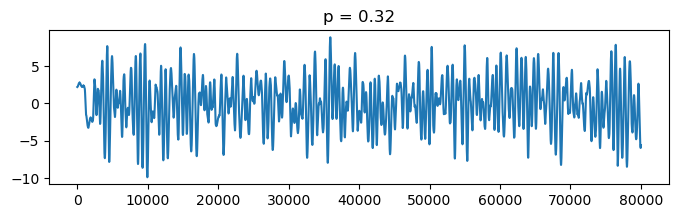

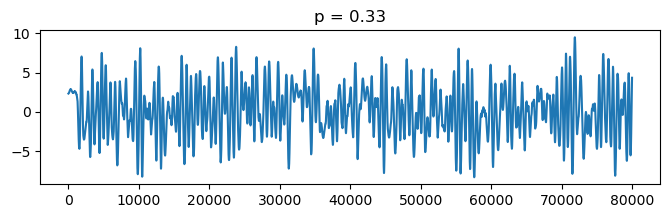

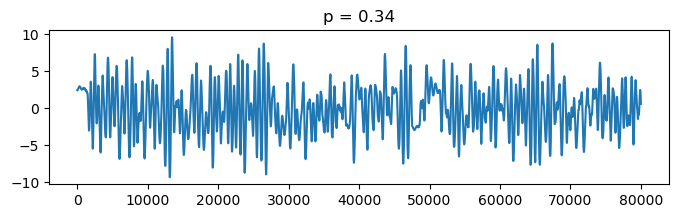

In [74]:
for p_idx in range(len_p_list):
    plt.figure(figsize = (8,2))
    plt.plot(U_train[p_idx][:,0])
    plt.title(f"p = {p_list[p_idx]}")

In [75]:
U_mean = U_data.mean(axis = 0)
U_std = U_data.std(axis = 0)
m = U_data.min(axis=0)
M = U_data.max(axis=0)
U_norm = M-m 
scale = (U_mean, U_std)

In [58]:
min_dict
# hyperparameters for p_list = [2.0,3.0,4.0]

{'params': array([[ 1.       ,  0.5      ,  4.5708819, -1.30103  ]]),
 'tikh': [0.001],
 'f': array([0.48032925])}

In [67]:
scale

(array([-5.05284969e-02, -6.69978810e-03,  5.73647903e-03,  1.37201609e-01,
         1.38291129e-01,  2.31303209e+01]),
 array([3.24646763e+00, 2.93621269e+00, 1.12998470e-03, 7.85202723e+00,
        8.88861723e+00, 8.59924401e+00]))

In [76]:
input_bias = np.array([np.mean(np.abs((U_data-scale[0])/scale[1]))])
print('Input bias: ', input_bias)
dim = U_train[0].shape[1]
#dim = U_train.shape[1]
print('System dimension: ', dim)
my_ESN = ESN(reservoir_size = 1200, dimension = dim, parameter_dimension = 1, reservoir_connectivity = 3, 
                input_scaling = 1.0, spectral_radius = 1.0,
                leak_factor = 1.0, input_bias = input_bias, input_normalization = scale, parameter_normalization=[P_mean,np.array([1.0])])

Input bias:  [0.71140133]
System dimension:  6
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [77]:
#my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-1, P_washout=None, P_train=None)
my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train)

In [ ]:
my_ESN.norm_p[0]

In [ ]:
plt.imshow(my_ESN.output_weights[0:50,:], aspect = 1)
plt.colorbar()
plt.xlabel("output state")
plt.ylabel("reservoir state")
plt.show()

plt.plot(data_dict["x"][1:-1:grid_upsample],my_ESN.output_weights[0:5,:].T)
plt.xlabel("x")
plt.ylabel("W out")
plt.legend(range(5), loc = "upper right")
plt.show()

In [24]:
def L2_error(y, y_pred):
    return np.linalg.norm(y-y_pred, 'fro')

In [ ]:
X_pred_train, Y_pred_train = my_ESN.closed_loop_with_washout(U_washout_train, N_t = N_train-1)
Y_pred_train = Y_pred_train[1:,:]
X_pred_val, Y_pred_val = my_ESN.closed_loop_with_washout(U_washout_val, N_t = N_val-1)
Y_pred_val = Y_pred_val[1:,:]

train_error = L2_error(Y_train, Y_pred_train)
val_error = L2_error(Y_val, Y_pred_val)
print("Train error: ", train_error)
print("Validation error: ", val_error)

for j in range(np.minimum(dim,1)):
    plt.figure(figsize=(16,4))
    plt.plot(t_train, Y_train[:,j])
    plt.plot(t_train, Y_pred_train[:,j],'--')
    plt.xlabel("t")
    plt.ylabel(f"q_{j}")
    plt.legend(["True", "ESN"])
for j in range(np.minimum(dim,1)):
    plt.figure(figsize=(16,4))
    plt.plot(t_val, Y_val[:,j])
    plt.plot(t_val, Y_pred_val[:,j],'--')
    plt.xlabel("t")
    plt.ylabel(f"q_{j}")
    plt.legend(["True", "ESN"])

Train error:  6119.7339323121405
Validation error:  1891.5350968627029
Train error:  5960.093806658622
Validation error:  1934.5771431468183
Train error:  6141.024594860741
Validation error:  1911.4869683576521


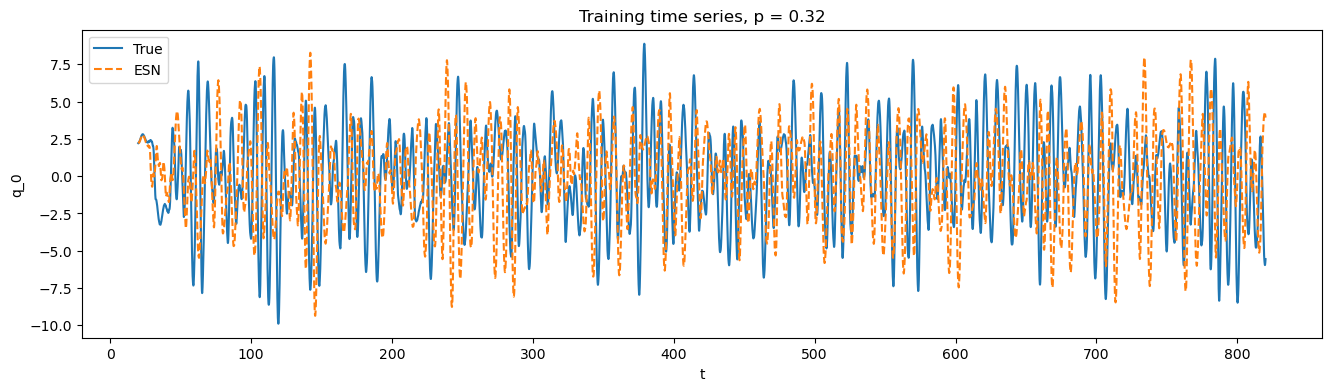

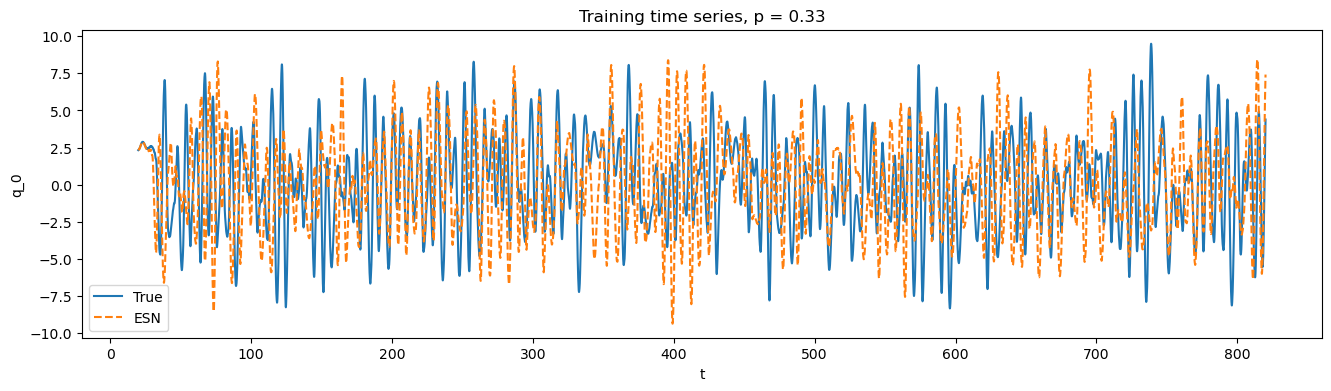

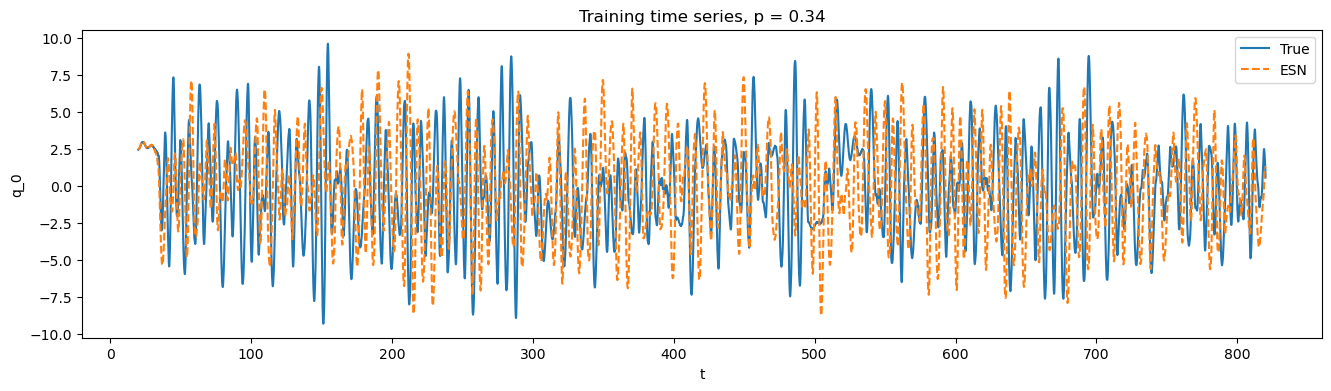

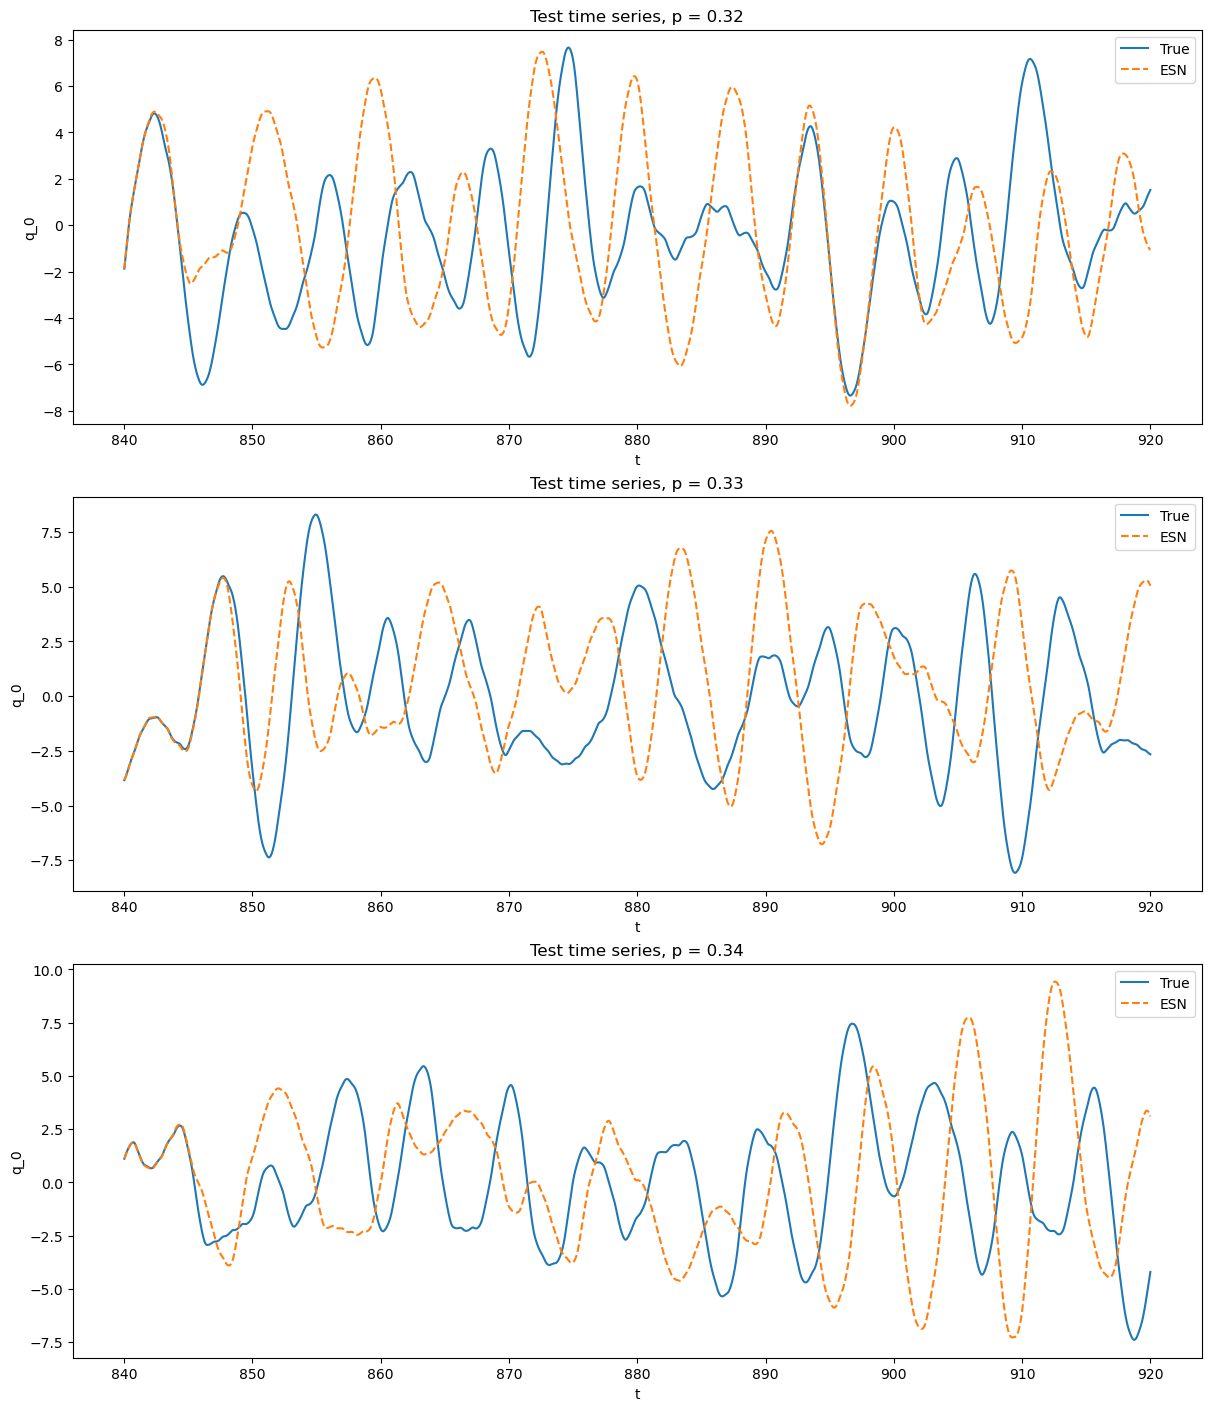

In [78]:
Y_pred_train = [None]*len_p_list
for p_idx in range(len_p_list):
    _, Y_pred_train_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_train[p_idx], N_t = len(U_train[p_idx]), P_washout=P_washout_train[p_idx], P = P_train[p_idx])
    Y_pred_train[p_idx] = Y_pred_train_[1:,:]
    #my_lorenz63.t_lyap
    for j in range(np.minimum(dim,1)):
        plt.figure(figsize=(16,4))
        plt.plot(t_train[p_idx], Y_train[p_idx][:,j])
        plt.plot(t_train[p_idx], Y_pred_train[p_idx][:,j],'--')
        plt.title(f"Training time series, p = {p_list[p_idx]}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j}")
        plt.legend(["True", "ESN"])

Y_pred_val = [None]*len_p_list
plt.figure(figsize=(12,14), constrained_layout = True)
for p_idx in range(len_p_list):
    _, Y_pred_val_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_val[p_idx], N_t = len(U_val[p_idx]), P_washout=P_washout_val[p_idx], P = P_val[p_idx])
    Y_pred_val[p_idx] = Y_pred_val_[1:,:]
    #my_lorenz63.t_lyap
    plt.subplot(len_p_list,1,p_idx+1)
    for j in range(np.minimum(dim,1)):
        #plt.plot(t_val, Y_val[:,j]-Y_pred_val[:,j])
        plt.plot(t_val[p_idx][:], Y_val[p_idx][:,j])
        plt.plot(t_val[p_idx][:], Y_pred_val[p_idx][:,j],'--')
        plt.title(f"Test time series, p = {p_list[p_idx]}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j}")
        plt.legend(["True", "ESN"])

# calculate error
for p_idx in range(len_p_list):
    train_error = L2_error(Y_train[p_idx], Y_pred_train[p_idx])
    val_error = L2_error(Y_val[p_idx], Y_pred_val[p_idx])
    print("Train error: ", train_error)
    print("Validation error: ", val_error)

Running solver.
Train error:  7613.881376947837
Validation error:  2553.1358577682204
Running solver.
Train error:  5559.847889062656
Validation error:  1652.619632026994
Running solver.
Train error:  5816.717800272981
Validation error:  1839.246478995687
Running solver.
Train error:  5596.8989059548185
Validation error:  1766.455402970446
Running solver.
Train error:  1045.4282289178095
Validation error:  327.3433300108258
Running solver.
Train error:  1703.0568788702826
Validation error:  537.1867090601397


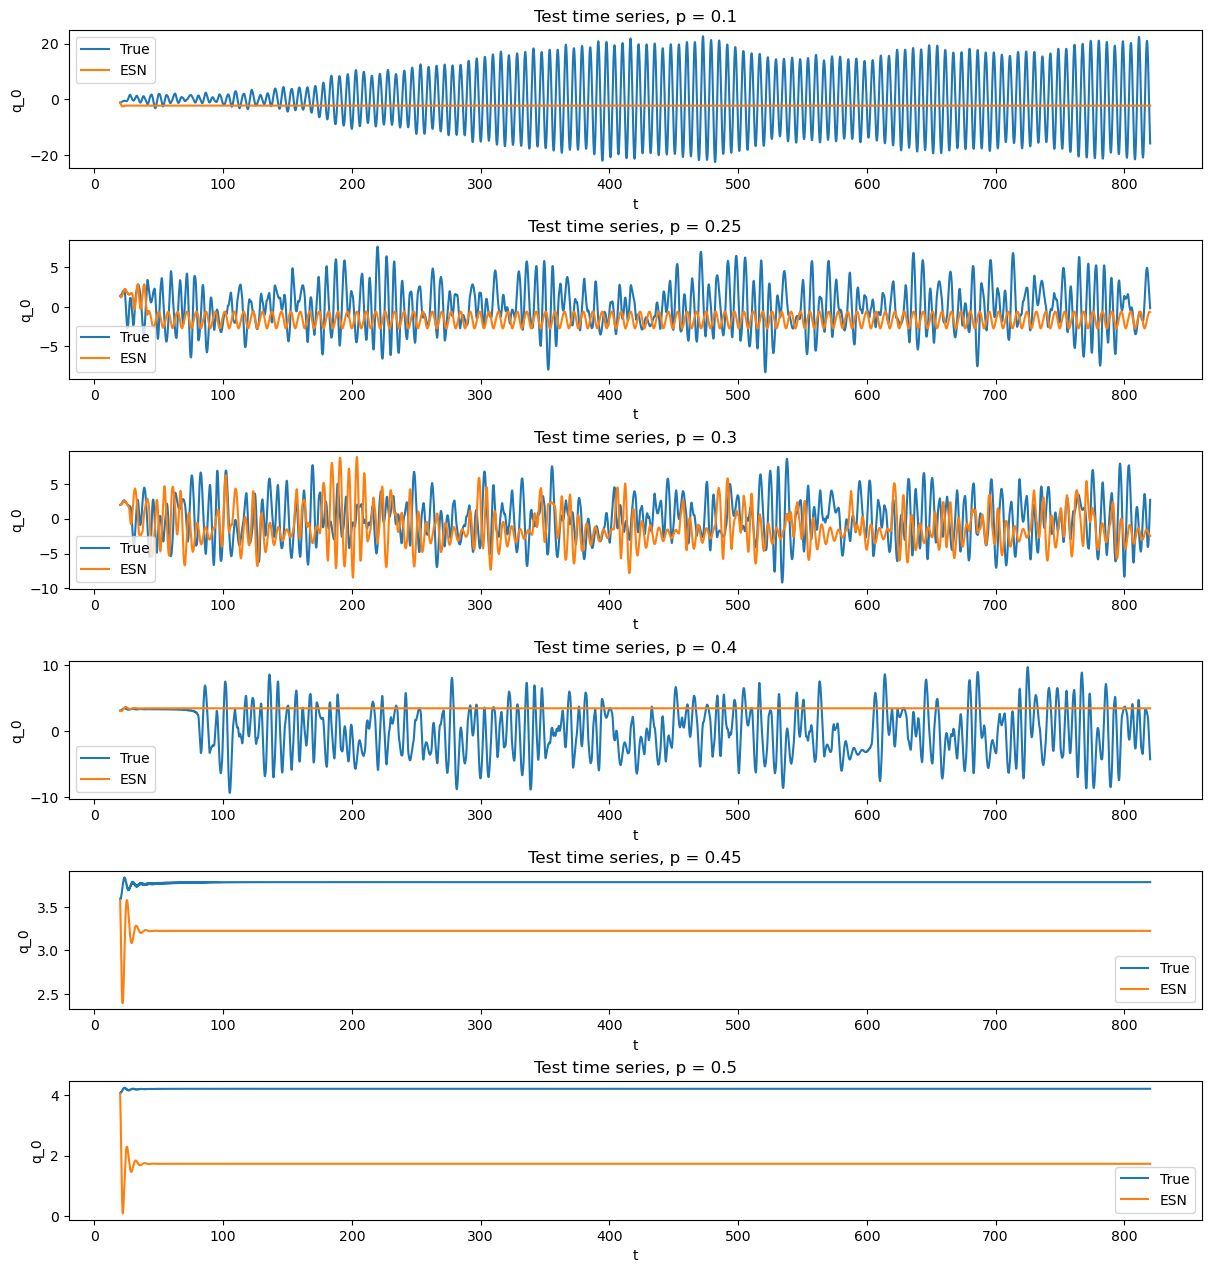

In [79]:
#pp_test_list = [1.0,1.5,2.3,2.7,3.5,5.3,5.7]
pp_test_name_list = ["1","1_5","2_3","2_7","3_5","5_3","5_7"]
pp_test_list = [0.1,0.25,0.3,0.4,0.45,0.5]
plt.figure(figsize=(12,14), constrained_layout = True)
for test_idx, pp_test in enumerate(pp_test_list): 
    #test_str = f"data/rijke_kings_beta_{pp_test_name_list[test_idx]}_tau_0_2_long_fine.h5"
    #U_washout_test, U_test, Y_test, t_test, U_washout_testval, U_testval, Y_testval, t_testval, U_data_test = load_data(test_str)
    U_washout_test, U_test, Y_test, t_test, U_washout_testval, U_testval, Y_testval, t_testval, U_data_test = load_data_roesslor(a = 0.1, b = 0.1, c = 18, mu = 10, r = 28, d = 8/3, epsilon = pp_test)
    P_test = pp_test*np.ones((len(U_test),1))
    P_testval = pp_test*np.ones((len(U_testval),1))
    P_washout_test = pp_test*np.ones((len(U_washout_test),1))
    P_washout_testval = pp_test*np.ones((len(U_washout_testval),1))
    X_pred_test, Y_pred_test = my_ESN.closed_loop_with_washout(U_washout = U_washout_test, N_t = len(U_test), P_washout=P_washout_test, P = P_test)
    Y_pred_test = Y_pred_test[1:,:]

    X_pred_testval, Y_pred_testval = my_ESN.closed_loop_with_washout(U_washout = U_washout_testval, N_t = len(U_testval), P_washout=P_washout_testval, P = P_testval)
    Y_pred_testval = Y_pred_testval[1:,:]
    plt.subplot(len(pp_test_name_list),1,test_idx+1)
    for j in range(np.minimum(dim,1)):
        #plt.figure(figsize=(16,4))
        plt.plot(t_test, Y_test[:,j])
        plt.plot(t_test, Y_pred_test[:,j])
        #plt.plot(t_testval[:], Y_testval[:,j])
        #plt.plot(t_testval[:], Y_pred_testval[:,j],'--')
        plt.title(f"Test time series, p = {pp_test}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j}")
        plt.legend(["True", "ESN"])

    test_error = L2_error(Y_test, Y_pred_test)
    testval_error = L2_error(Y_testval, Y_pred_testval)
    print("Train error: ", test_error)
    print("Validation error: ", testval_error)

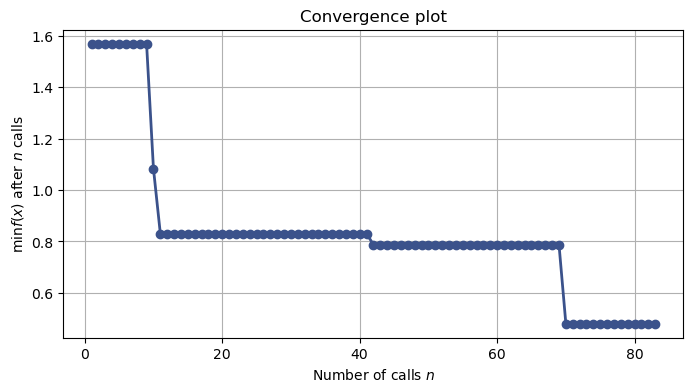

In [56]:
from adjoint_esn.validation import validate

#range for hyperparameters (spectral radius and input scaling)
spec_in     = 0.1    
spec_end    = 1.0   
in_scal_in  = np.log10(0.05)
in_scal_end = np.log10(5.)
leak_in     = 0.1    
leak_end    = 1.0  
param_norm_var_in = np.log10(0.05)
param_norm_var_end = np.log10(5.)
param_norm_mean_in = 0.0
param_norm_mean_end = 2*P_mean
grid_range = [[spec_in, spec_end],[in_scal_in, in_scal_end],[param_norm_mean_in, param_norm_mean_end],[param_norm_var_in, param_norm_var_end]]
# In case we want to start from a grid_search, 
# the first n_grid_x*n_grid_y points are from grid search
param_names = ['spectral_radius','input_scaling','parameter_normalization_mean','parameter_normalization_var']
param_scales = ['uniform', 'log10','uniform','log10']
n_grid = [3, 3, 3, 3]

N_washout = 400
N_val = 1000
ESN_dict = {'reservoir_size': 1200, 
            'dimension' : dim, 
            'parameter_dimension' : 1,
            'reservoir_connectivity' : 3,
            'input_normalization': scale, 
            'input_bias' : input_bias}
min_dict = validate(n_grid, grid_range, param_names, param_scales, 
    n_bo = 2, n_initial = 0, n_ensemble = 1, ESN_dict = ESN_dict, U_washout = U_washout_train, 
    U = U_train, Y = Y_train, P_washout = P_washout_train, P = P_train,
    n_folds = 2, N_init_steps = N_washout, N_fwd_steps = 80, N_washout_steps = N_washout, N_val_steps = N_val)

In [57]:
min_dict

{'params': array([[ 1.       ,  0.5      ,  4.5708819, -1.30103  ]]),
 'tikh': [0.001],
 'f': array([0.48032925])}

In [ ]:
p_idx = 1
X_pred_train, Y_pred_train_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_train[p_idx], N_t = len(U_train[p_idx]), P_washout=P_washout_train[p_idx], P = P_train[p_idx])
Y_pred_train = Y_pred_train_[1:,:]

In [ ]:
# Calculate jacobian of the reservoir states analytically
x_0 = X_pred_train[0,:]
p_0 = P_train[p_idx][0]
x_1 = X_pred_train[1,:]
my_jac = my_ESN.jac(x_1)
# now compare this jacobian to the numerical one
def closed_loop_step(x_0, p_0):
    x_0_augmented = np.hstack((x_0, my_ESN.b_out))
    y_0 = np.dot(x_0_augmented, my_ESN.W_out)
    x_1 = my_ESN.step(x_0, y_0, p_0)
    return x_1
h = 1e-5
my_jac_num = np.zeros((my_ESN.N_reservoir,my_ESN.N_reservoir))
dJ_dx_0_num = np.zeros((my_ESN.N_reservoir))
for i in range(my_ESN.N_reservoir):
    x_0_left = x_0.copy()
    x_0_left[i] -= h
    x_0_right = x_0.copy()
    x_0_right[i] += h
    x_1_left = closed_loop_step(x_0_left, p_0)
    x_1_right = closed_loop_step(x_0_right, p_0)
    J_1_left = np.sum(x_1_left**2)
    J_1_right = np.sum(x_1_right**2)
    dJ_dx_0_num[i] = (J_1_right-J_1_left)/(2*h)
    for j in range(my_ESN.N_reservoir):
        my_jac_num[j,i] = (x_1_right[j]-x_1_left[j])/(2*h)
        
print("Difference of analytical vs numerical Jacobian:",np.where(np.abs(my_jac_num-my_jac.toarray()) > 1e-8))

In [ ]:
# Find the adjoint for one step
dJ_dx_1 = 2*x_1
dx_1_dx_0 = my_ESN.jac(x_1).toarray()
dJ_dx_0 = np.dot(dJ_dx_1,dx_1_dx_0)
v_1 = dJ_dx_1
v_0 = np.dot(dx_1_dx_0.T,v_1)
print("Difference of direct vs adjoint calculation:", np.where(dJ_dx_0 != v_0))
print("Difference of direct vs numerical calculation:",np.where(np.abs(dJ_dx_0_num-dJ_dx_0) > 1e-8))
print("Difference of adjoint vs numerical calculation:",np.where(np.abs(dJ_dx_0_num-v_0) > 1e-8))

In [ ]:
# calculate gradient for a timeseries, direct method
# terminal state objective 
#N = X_pred_train.shape[0]
N = 10
q_prev = np.eye(my_ESN.N_reservoir)
for i in np.arange(1,N):
    q = np.dot(my_ESN.jac(X_pred_train[i,:]).toarray(),q_prev)
    q_prev = q
dJ_dx_0 = np.dot(2*X_pred_train[N-1,:],q)

In [ ]:
# calculate gradient for a timeseries, direct method
# time averaged objective
#N = X_pred_train.shape[0]
N = 10
q_prev = np.eye(my_ESN.N_reservoir)
dJ_dx_0 = 2*X_pred_train[0,:]
for i in np.arange(1,N):
    q = np.dot(my_ESN.jac(X_pred_train[i,:]).toarray(),q_prev)
    q_prev = q
    dJ_dx_0 += np.dot(2*X_pred_train[i,:],q)
dJ_dx_0 = (1/N)*dJ_dx_0

In [ ]:
# calculate gradient for a timeseries, adjoint method
# terminal state objective 
v_prev = 2*X_pred_train[N-1,:]
for i in np.arange(N-1,0,-1):
    v = np.dot(my_ESN.jac(X_pred_train[i,:]).toarray().T,v_prev)
    v_prev = v
dJ_dx_0_adj = v

In [ ]:
# calculate gradient for a timeseries, adjoint method
# time averaged objective
v_prev = 2*X_pred_train[N-1,:]
for i in np.arange(N-1,0,-1):
    v = np.dot(my_ESN.jac(X_pred_train[i,:]).toarray().T,v_prev)+2*X_pred_train[i-1,:].T
    v_prev = v
dJ_dx_0_adj = (1/N)*v

In [ ]:
# calculate gradient for a timeseries, numerical method
# terminal state objective 
x_0 = X_pred_train[0,:]
h = 1e-5
dJ_dx_0_num = np.zeros((my_ESN.N_reservoir))
for i in range(my_ESN.N_reservoir):
    x_0_left = x_0.copy()
    x_0_left[i] -= h
    x_0_right = x_0.copy()
    x_0_right[i] += h
    X_left, _ = my_ESN.closed_loop(x_0_left, N-1, P_train[p_idx])
    X_right, _ =  my_ESN.closed_loop(x_0_right, N-1, P_train[p_idx])
    J_left = np.sum(X_left[-1,:]**2)
    J_right = np.sum(X_right[-1,:]**2)
    dJ_dx_0_num[i] = (J_right-J_left)/(2*h)

In [ ]:
# calculate gradient for a timeseries, numerical method
# time averaged objective
x_0 = X_pred_train[0,:]
h = 1e-5
dJ_dx_0_num = np.zeros((my_ESN.N_reservoir))
for i in range(my_ESN.N_reservoir):
    x_0_left = x_0.copy()
    x_0_left[i] -= h
    x_0_right = x_0.copy()
    x_0_right[i] += h
    X_left, _ = my_ESN.closed_loop(x_0_left, N-1, P_train[p_idx])
    X_right, _ =  my_ESN.closed_loop(x_0_right, N-1, P_train[p_idx])
    J_left = np.mean(np.sum(X_left**2, axis = 1))
    J_right = np.mean(np.sum(X_right**2, axis = 1))
    dJ_dx_0_num[i] = (J_right-J_left)/(2*h)

In [ ]:
print("Difference of direct vs adjoint calculation:", np.where(np.abs(dJ_dx_0 - dJ_dx_0_adj) > 1e-12))
print("Difference of direct vs numerical calculation:", np.where(np.abs(dJ_dx_0 - dJ_dx_0_num) > 1e-5))

In [ ]:
# Taylor test
epsilon_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
J_0 = np.mean(np.sum(X_pred_train[:N,:]**2, axis = 1))
taylor = np.zeros((len(epsilon_list),my_ESN.N_reservoir))
for epsilon_idx, epsilon in enumerate(epsilon_list):
    for i in range(my_ESN.N_reservoir):
        x_0_right = x_0.copy()
        x_0_right[i] += epsilon
        X_right, _ =  my_ESN.closed_loop(x_0_right, N-1, P_train[p_idx])
        J_1 = np.mean(np.sum(X_right**2, axis = 1))
        taylor[epsilon_idx, i] = J_1-J_0-epsilon*dJ_dx_0_adj[i]

In [ ]:
plt.plot(epsilon_list,np.abs(taylor[:,0]),'o-')
plt.xlabel("log10(epsilon)")
plt.ylabel("|log10(J1-J0-epsilon*dJ/dx0)|")
plt.xscale("log")
plt.yscale("log")
plt.title("Taylor test")
plt.show()

In [ ]:
p_list

In [ ]:
p_idx = 1
X_pred_train, Y_pred_train_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_train[p_idx], N_t = len(U_train[p_idx]), P_washout=P_washout_train[p_idx], P = P_train[p_idx])
Y_pred_train = Y_pred_train_[1:,:]

In [ ]:
# calculate gradient dJ/dp for a timeseries, direct method
# terminal state objective 
#N = X_pred_train.shape[0]
N = 1000
q = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
q_prev = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
for i in np.arange(1,N):
    q = my_ESN.drdp(X_pred_train[i,:]).toarray()+np.dot(my_ESN.jac(X_pred_train[i,:]).toarray(),q_prev)
    q_prev = q
dJ_dp = np.dot(2*X_pred_train[N-1,:],q)

In [ ]:
# calculate gradient for a timeseries, direct method
# time averaged objective
#N = X_pred_train.shape[0]
N = 1000
q = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
q_prev = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
dJ_dp = np.zeros(my_ESN.N_param_dim)
for i in np.arange(1,N):
    q = my_ESN.drdp(X_pred_train[i,:]).toarray()+np.dot(my_ESN.jac(X_pred_train[i,:]).toarray(),q_prev)
    q_prev = q   
    dJ_dp += np.dot(2*X_pred_train[i,:],q)
dJ_dp = (1/N)*dJ_dp

In [ ]:
# calculate gradient dJ/dp for a timeseries, adjoint method
# terminal state objective 
v_prev = 2*X_pred_train[N-1,:]
dJ_dp_adj = np.zeros(my_ESN.N_param_dim)
for i in np.arange(N-1,0,-1):
    dJ_dp_adj += np.dot(my_ESN.drdp(X_pred_train[i,:]).toarray().T,v_prev)
    v = np.dot(my_ESN.jac(X_pred_train[i,:]).toarray().T,v_prev)
    v_prev = v

In [ ]:
# calculate gradient for a timeseries, adjoint method
# time averaged objective
v_prev = (1/N)*2*X_pred_train[N-1,:]
dJ_dp_adj = np.zeros(my_ESN.N_param_dim)
for i in np.arange(N-1,0,-1):
    dJ_dp_adj += np.dot(my_ESN.drdp(X_pred_train[i,:]).toarray().T,v_prev)
    v = np.dot(my_ESN.jac(X_pred_train[i,:]).toarray().T,v_prev)+ (1/N)*2*X_pred_train[i-1,:].T
    v_prev = v

In [ ]:
# calculate gradient for a timeseries, numerical method
# terminal state objective 
h = 1e-3
dJ_dp_num = np.zeros((my_ESN.N_param_dim))
for i in range(my_ESN.N_param_dim):
    P_left = P_train[p_idx].copy()
    P_left[:,i] -= h
    P_right = P_train[p_idx].copy()
    P_right[:,i] += h
    X_left, _ = my_ESN.closed_loop(X_pred_train[0,:], N-1, P_left)
    X_right, _ =  my_ESN.closed_loop(X_pred_train[0,:], N-1, P_right)
    J_left = np.sum(X_left[-1,:]**2)
    J_right = np.sum(X_right[-1,:]**2)
    dJ_dp_num[i] = (J_right-J_left)/(2*h)

In [ ]:
# calculate gradient for a timeseries, numerical method
# time averaged objective 
h = 1e-3
dJ_dp_num = np.zeros((my_ESN.N_param_dim))
for i in range(my_ESN.N_param_dim):
    P_left = P_train[p_idx].copy()
    P_left[:,i] -= h
    P_right = P_train[p_idx].copy()
    P_right[:,i] += h
    X_left, _ = my_ESN.closed_loop(X_pred_train[0,:], N-1, P_left)
    X_right, _ =  my_ESN.closed_loop(X_pred_train[0,:], N-1, P_right)
    J_left = np.mean(np.sum(X_left**2, axis = 1))
    J_right = np.mean(np.sum(X_right**2, axis = 1))
    dJ_dp_num[i] = (J_right-J_left)/(2*h)

In [ ]:
dJ_dp

In [ ]:
dJ_dp_adj

In [ ]:
dJ_dp_num

In [ ]:
# Taylor test
epsilon_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
J_0 = np.mean(np.sum(X_pred_train[:N,:]**2, axis = 1))
taylor = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
for epsilon_idx, epsilon in enumerate(epsilon_list):
    for i in range(my_ESN.N_param_dim):
        P_right = P_train[p_idx].copy()
        P_right[:,i] += epsilon
        X_right, _ =  my_ESN.closed_loop(X_pred_train[0,:], N-1, P_right)
        J_1 = np.mean(np.sum(X_right**2, axis = 1))
        taylor[epsilon_idx, i] = J_1-J_0-epsilon*dJ_dp_adj[i]

In [ ]:
plt.plot(epsilon_list,np.abs(taylor[:,0]),'o-')
plt.xlabel("log10(epsilon)")
plt.ylabel("|log10(J1-J0-epsilon*dJ/dp)|")
plt.xscale("log")
plt.yscale("log")
plt.title("Taylor test")
plt.show()